In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [5]:
import warnings
warnings.filterwarnings("ignore")

Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

In [6]:
import pandas as pd
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
df = pd.read_csv('../data/doc_train.csv')

In [5]:
df.columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'clean_text', 'token_words', 'join_token', 'Date',
       'year', 'words_count', 'unique_words', 'new_token_words', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4'],
      dtype='object')

In [8]:
df[['Text', 'clean_text', 'new_token_words']].iloc[:2]

,Text,clean_text,new_token_words
0,I was pleasantly surprised at these little sna...,i was pleasantly surprised at these little sna...,pleasantli surpris littl snack thought sure wo...
1,"Great coffee, available only in the fall. Hav...",great coffee available only in the fall have ...,great coffe avail fall green mountain product ...


In [9]:
vocab_size = 5000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [12]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", 'im', 'youre', 'br' ]


In [13]:
def remove_stop_words_one_more_time(row):
    row_list = row.split(" ")
    return " ".join([word for word in row_list if word not in stopwords])

In [14]:
test = remove_stop_words_one_more_time(df['clean_text'].iloc[0])
test

'pleasantly surprised little snacks  thought sure wouldnt fill  just right amount crunch hint cinnamon flavor not overpowering bitter'

In [15]:
texts = []
labels = []
with open('../data/doc_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        label=row['Score']
        text = row['clean_text']
        labels.append(label)
        for word in stopwords:
            stop = " "+word+" "
            text = text.replace(stop," ")
        texts.append(text)


In [16]:
texts[:3]

['i pleasantly surprised little snacks  thought sure wouldnt fill  just right amount crunch hint cinnamon flavor not overpowering bitter',
 'great coffee available fall  green mountain products good  like buy k cups lesser price',
 'this item came fast french bulldog ate stuff even fastergreat product great price fast shipping recommend dog lovers healthy dog treat']

In [17]:
labels[:10]

['4', '5', '5', '5', '5', '3', '5', '4', '4', '1']

# split 80%/20 % to train and test in train dataset (doc_train.csv)

In [18]:
train_size = int(len(texts) * training_portion)

train_text = texts[:train_size]
train_labels = labels[:train_size]

test_text = texts[train_size:]
test_labels = labels[train_size:]

In [19]:
train_index = np.arange(train_size)
train_df = df[df.index.isin(train_index)]
test_df = df[~df.index.isin(train_index)]

In [20]:
train_index= train_df['Score'].value_counts()
train_index

5    126069
4     29243
1     20181
3     15927
2     11276
Name: Score, dtype: int64

In [21]:
train_index.iloc[0]

126069

In [29]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [30]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

In [31]:
label_seq = pd.Series(np.reshape(training_label_seq, (-1,)))
label_seq.value_counts()

1    126069
2     29243
3     20181
4     15927
5     11276
dtype: int64

In [32]:
label_seq[0]

2

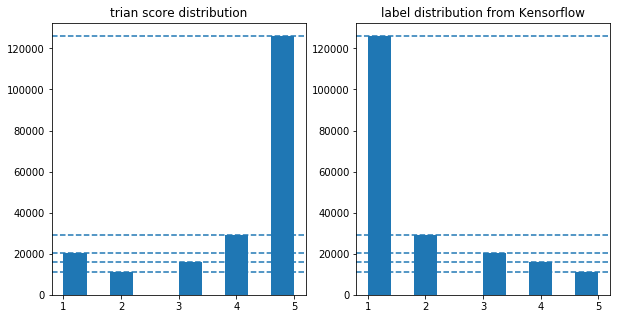

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize =(10,5))
axs[0].hist(train_df['Score'])
axs[0].set_title('trian score distribution')
axs[0].axhline(train_index.iloc[0], linestyle = '--')
axs[0].axhline(train_index.iloc[1], linestyle = '--')
axs[0].axhline(train_index.iloc[2], linestyle = '--')
axs[0].axhline(train_index.iloc[3], linestyle = '--')
axs[0].axhline(train_index.iloc[4], linestyle = '--')
axs[1].hist(label_seq)
axs[1].set_title('label distribution from Kensorflow')
axs[1].axhline(train_index.iloc[0], linestyle = '--')
axs[1].axhline(train_index.iloc[1], linestyle = '--')
axs[1].axhline(train_index.iloc[2], linestyle = '--')
axs[1].axhline(train_index.iloc[3], linestyle = '--')
axs[1].axhline(train_index.iloc[4], linestyle = '--');

In [26]:
print(word_index)

{'<OOV>': 1, 'not': 2, 'like': 3, 'good': 4, 'i': 5, 'coffee': 6, 'just': 7, 'one': 8, 'taste': 9, 'great': 10, 'product': 11, 'flavor': 12, 'can': 13, 'will': 14, 'love': 15, 'food': 16, 'tea': 17, 'get': 18, 'no': 19, 'really': 20, 'dont': 21, 'much': 22, 'also': 23, 'use': 24, 'little': 25, 'time': 26, 'amazon': 27, 'buy': 28, 'price': 29, 'tried': 30, 'even': 31, 'this': 32, 'well': 33, 'make': 34, 'best': 35, 'ive': 36, 'dog': 37, 'now': 38, 'try': 39, 'better': 40, 'find': 41, 'water': 42, 'eat': 43, 'first': 44, 'chocolate': 45, 'used': 46, 'bag': 47, 'cup': 48, 'found': 49, 'drink': 50, 'sugar': 51, 'bought': 52, 'sweet': 53, 'made': 54, 'box': 55, 'think': 56, 'way': 57, 'two': 58, 'tastes': 59, 'still': 60, 'since': 61, 'day': 62, 'bit': 63, 'go': 64, 'know': 65, 'give': 66, 'order': 67, 'got': 68, 'store': 69, 'recommend': 70, 'nice': 71, 'dogs': 72, 'many': 73, 'it': 74, 'want': 75, 'cant': 76, 'something': 77, 'never': 78, 'flavors': 79, 'delicious': 80, 'didnt': 81, 'favo

In [27]:
# maximum of the sequence is 120 and fitting index of each word start the begining of the sequence 
train_padded[1]

array([  10,    6,  301, 1143,  146,  570,  137,    4,    3,   28,  685,
        285, 4846,   29,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

# One Layer with 24 neuron

In [71]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           80000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 150       
Total params: 80,558
Trainable params: 80,558
Non-trainable params: 0
_________________________________________________________________


In [60]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/30
202696/202696 - 8s - loss: 0.8930 - accuracy: 0.6761 - val_loss: 0.7701 - val_accuracy: 0.7093
Epoch 2/30
202696/202696 - 8s - loss: 0.7489 - accuracy: 0.7178 - val_loss: 0.7421 - val_accuracy: 0.7211
Epoch 3/30
202696/202696 - 8s - loss: 0.7261 - accuracy: 0.7255 - val_loss: 0.7354 - val_accuracy: 0.7241
Epoch 4/30
202696/202696 - 8s - loss: 0.7134 - accuracy: 0.7309 - val_loss: 0.7311 - val_accuracy: 0.7266
Epoch 5/30
202696/202696 - 8s - loss: 0.7011 - accuracy: 0.7357 - val_loss: 0.7245 - val_accuracy: 0.7300
Epoch 6/30
202696/202696 - 9s - loss: 0.6898 - accuracy: 0.7411 - val_loss: 0.7218 - val_accuracy: 0.7312
Epoch 7/30
202696/202696 - 9s - loss: 0.6804 - accuracy: 0.7448 - val_loss: 0.7290 - val_accuracy: 0.7322
Epoch 8/30
202696/202696 - 8s - loss: 0.6720 - accuracy: 0.7484 - val_loss: 0.7281 - val_accuracy: 0.7339
Epoch 9/30
202696/202696 - 8s - loss: 0.6636 - accuracy: 0.7520 - val_loss: 0.7214 - val_accuracy: 0.

In [23]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Change embedding dimension 

In [65]:
loss = {}
acc = {}


embedding_num = [14, 18, 26]
for i in embedding_num:
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    m_epochs = 10
    history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=0)
    loss['loss' + str(i)] = history.history['loss']
    loss['val_loss' + str(i)] = history.history['val_loss']
    acc['acc' + str(i)] = history.history['accuracy']
    acc['val_acc' + str(i)] = history.history['val_accuracy']
         

loss_dim_df=pd.DataFrame(loss)
acc_dim_df = pd.DataFrame(acc)

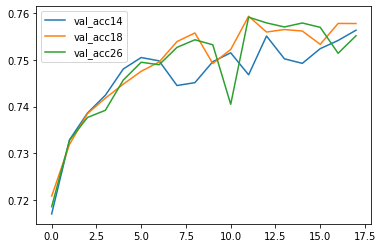

In [70]:
#acc_dim_df[['val_acc14','val_acc18','val_acc26']].plot()

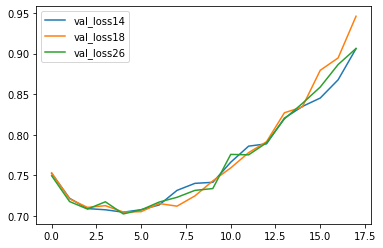

In [73]:
#loss_dim_df[['val_loss14','val_loss18','val_loss26']].plot()

# Change Voc Size

In [78]:
vocab_sizes = [3000,10000,20000, 30000]

loss = {}
acc = {}
for n in vocab_sizes:
    vocab_size = n
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_text)
    word_index = tokenizer.word_index

    train_sequences = tokenizer.texts_to_sequences(train_text)
    train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
    
    validation_sequences = tokenizer.texts_to_sequences(test_text)
    validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)
    
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    num_epochs = 18
    history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=0)
    loss['loss' + " " + str(n)] = history.history['loss']
    loss['val_loss' +  " " + str(n)] = history.history['val_loss']
    acc['acc' + " " + str(n)] = history.history['accuracy']
    acc['val_acc' + " " + str(n)] = history.history['val_accuracy']

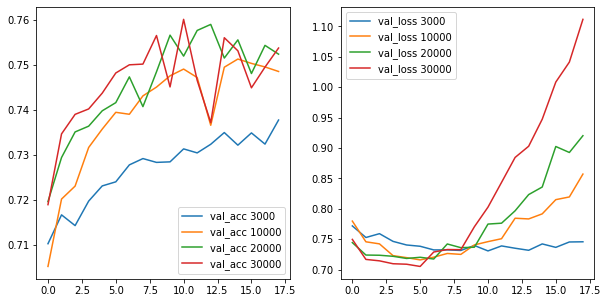

In [92]:
loss_dim_df_size=pd.DataFrame(loss)
acc_dim_df_size = pd.DataFrame(acc)
interested_cols = [col for col in acc_dim_df_size.columns if col.startswith('val')]
interested_cols_1 = [col for col in loss_dim_df_size.columns if col.startswith('val')]
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (10,5))
acc_dim_df_size[interested_cols].plot(ax = axs[0])
loss_dim_df_size[interested_cols_1].plot(ax = axs[1])


In [54]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [55]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(5000, 16)


In [56]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [261]:
vocab_size = 5000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

# Adding new layers

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 50
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/50
202696/202696 - 9s - loss: 0.8967 - accuracy: 0.6722 - val_loss: 0.7819 - val_accuracy: 0.7065
Epoch 2/50
202696/202696 - 8s - loss: 0.7520 - accuracy: 0.7167 - val_loss: 0.7465 - val_accuracy: 0.7212
Epoch 3/50
202696/202696 - 8s - loss: 0.7265 - accuracy: 0.7256 - val_loss: 0.7382 - val_accuracy: 0.7232
Epoch 4/50
202696/202696 - 8s - loss: 0.7139 - accuracy: 0.7305 - val_loss: 0.7414 - val_accuracy: 0.7217
Epoch 5/50
202696/202696 - 8s - loss: 0.7013 - accuracy: 0.7353 - val_loss: 0.7279 - val_accuracy: 0.7286
Epoch 6/50
202696/202696 - 8s - loss: 0.6879 - accuracy: 0.7409 - val_loss: 0.7234 - val_accuracy: 0.7326
Epoch 7/50
202696/202696 - 8s - loss: 0.6765 - accuracy: 0.7461 - val_loss: 0.7286 - val_accuracy: 0.7328
Epoch 8/50
202696/202696 - 8s - loss: 0.6668 - accuracy: 0.7505 - val_loss: 0.7250 - val_accuracy: 0.7353
Epoch 9/50
202696/202696 - 8s - loss: 0.6576 - accuracy: 0.7548 - val_loss: 0.7288 - val_accuracy: 0.

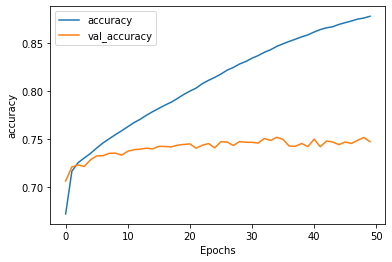

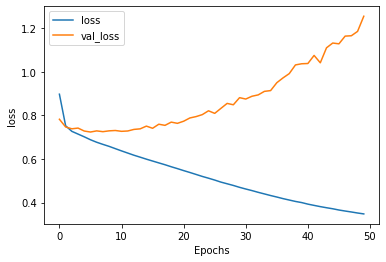

In [43]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

    this model is overfitting to train dataset since val_loss increases as the number of epochs increases

Below are parameters used for the above models

- vocab_size = 5000

- embedding_dim = 16

- max_length = 120

- trunc_type='post'

- padding_type='post'

- oov_tok = ""

- training_portion = .8

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 50
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/50
202696/202696 - 9s - loss: 0.8506 - accuracy: 0.6878 - val_loss: 0.7563 - val_accuracy: 0.7178
Epoch 2/50
202696/202696 - 9s - loss: 0.7406 - accuracy: 0.7210 - val_loss: 0.7420 - val_accuracy: 0.7204
Epoch 3/50
202696/202696 - 10s - loss: 0.7214 - accuracy: 0.7285 - val_loss: 0.7313 - val_accuracy: 0.7288
Epoch 4/50
202696/202696 - 9s - loss: 0.7025 - accuracy: 0.7375 - val_loss: 0.7242 - val_accuracy: 0.7312
Epoch 5/50
202696/202696 - 9s - loss: 0.6836 - accuracy: 0.7449 - val_loss: 0.7225 - val_accuracy: 0.7357
Epoch 6/50
202696/202696 - 9s - loss: 0.6683 - accuracy: 0.7519 - val_loss: 0.7224 - val_accuracy: 0.7366
Epoch 7/50
202696/202696 - 9s - loss: 0.6538 - accuracy: 0.7571 - val_loss: 0.7212 - val_accuracy: 0.7400
Epoch 8/50
202696/202696 - 9s - loss: 0.6396 - accuracy: 0.7627 - val_loss: 0.7367 - val_accuracy: 0.7418
Epoch 9/50
202696/202696 - 9s - loss: 0.6274 - accuracy: 0.7681 - val_loss: 0.7211 - val_accuracy: 0

Adding two more layers leads to almost 2% increase in val_accuracy

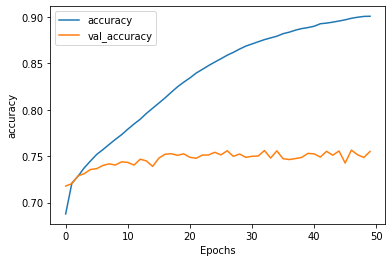

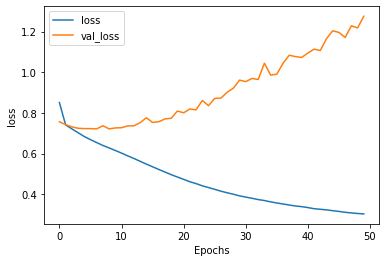

In [45]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Below are parameters used for the above models 

- vocab_size = 5000

- embedding_dim = 16

- max_length = 120

- trunc_type='post'

- padding_type='post'

- oov_tok = "<OOV>"
    
- training_portion = .8

In [49]:
def change_vocab_size_with_vorbose_more_layer(n):
    vocab_size = n
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_text)
    word_index = tokenizer.word_index

    train_sequences = tokenizer.texts_to_sequences(train_text)
    train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
    
    validation_sequences = tokenizer.texts_to_sequences(test_text)
    validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)
    
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    num_epochs = 18
    history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

Train on 202696 samples, validate on 50674 samples
Epoch 1/18
202696/202696 - 11s - loss: 0.8353 - accuracy: 0.6914 - val_loss: 0.7471 - val_accuracy: 0.7206
Epoch 2/18
202696/202696 - 11s - loss: 0.7239 - accuracy: 0.7277 - val_loss: 0.7451 - val_accuracy: 0.7248
Epoch 3/18
202696/202696 - 11s - loss: 0.6966 - accuracy: 0.7395 - val_loss: 0.7349 - val_accuracy: 0.7302
Epoch 4/18
202696/202696 - 11s - loss: 0.6697 - accuracy: 0.7505 - val_loss: 0.7120 - val_accuracy: 0.7404
Epoch 5/18
202696/202696 - 11s - loss: 0.6456 - accuracy: 0.7606 - val_loss: 0.7339 - val_accuracy: 0.7309
Epoch 6/18
202696/202696 - 11s - loss: 0.6256 - accuracy: 0.7694 - val_loss: 0.7297 - val_accuracy: 0.7370
Epoch 7/18
202696/202696 - 11s - loss: 0.6053 - accuracy: 0.7771 - val_loss: 0.7283 - val_accuracy: 0.7440
Epoch 8/18
202696/202696 - 11s - loss: 0.5873 - accuracy: 0.7844 - val_loss: 0.7200 - val_accuracy: 0.7495
Epoch 9/18
202696/202696 - 11s - loss: 0.5707 - accuracy: 0.7913 - val_loss: 0.7419 - val_acc

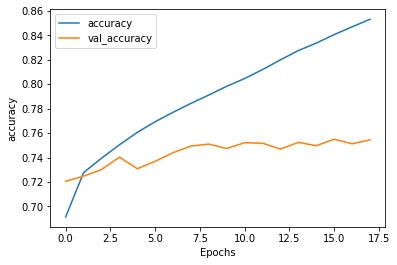

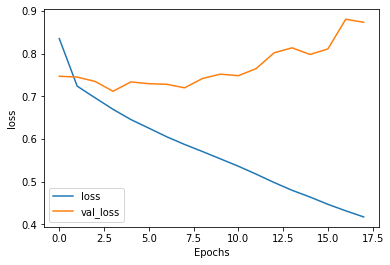

In [50]:
change_vocab_size_with_vorbose_more_layer(10000)

Train on 202696 samples, validate on 50674 samples
Epoch 1/18
202696/202696 - 13s - loss: 0.8327 - accuracy: 0.6935 - val_loss: 0.7487 - val_accuracy: 0.7213
Epoch 2/18
202696/202696 - 13s - loss: 0.7011 - accuracy: 0.7377 - val_loss: 0.7157 - val_accuracy: 0.7371
Epoch 3/18
202696/202696 - 13s - loss: 0.6633 - accuracy: 0.7534 - val_loss: 0.7182 - val_accuracy: 0.7347
Epoch 4/18
202696/202696 - 13s - loss: 0.6300 - accuracy: 0.7677 - val_loss: 0.7184 - val_accuracy: 0.7437
Epoch 5/18
202696/202696 - 13s - loss: 0.5980 - accuracy: 0.7797 - val_loss: 0.7090 - val_accuracy: 0.7506
Epoch 6/18
202696/202696 - 13s - loss: 0.5630 - accuracy: 0.7935 - val_loss: 0.7296 - val_accuracy: 0.7485
Epoch 7/18
202696/202696 - 14s - loss: 0.5295 - accuracy: 0.8079 - val_loss: 0.7518 - val_accuracy: 0.7488
Epoch 8/18
202696/202696 - 13s - loss: 0.5004 - accuracy: 0.8191 - val_loss: 0.7913 - val_accuracy: 0.7358
Epoch 9/18
202696/202696 - 13s - loss: 0.4754 - accuracy: 0.8281 - val_loss: 0.7940 - val_acc

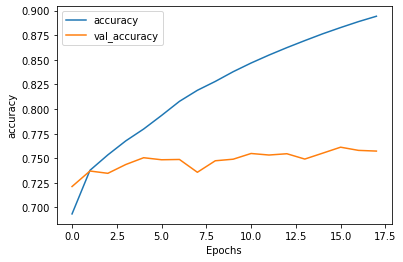

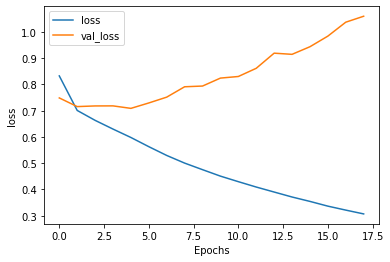

In [51]:
change_vocab_size_with_vorbose_more_layer(20000)

Train on 202696 samples, validate on 50674 samples
Epoch 1/18
202696/202696 - 19s - loss: 0.8310 - accuracy: 0.6942 - val_loss: 0.7298 - val_accuracy: 0.7284
Epoch 2/18
202696/202696 - 20s - loss: 0.6921 - accuracy: 0.7423 - val_loss: 0.7278 - val_accuracy: 0.7326
Epoch 3/18
202696/202696 - 19s - loss: 0.6442 - accuracy: 0.7621 - val_loss: 0.7061 - val_accuracy: 0.7455
Epoch 4/18
202696/202696 - 19s - loss: 0.6076 - accuracy: 0.7766 - val_loss: 0.7084 - val_accuracy: 0.7457
Epoch 5/18
202696/202696 - 19s - loss: 0.5751 - accuracy: 0.7886 - val_loss: 0.7245 - val_accuracy: 0.7475
Epoch 6/18
202696/202696 - 18s - loss: 0.5432 - accuracy: 0.8014 - val_loss: 0.7413 - val_accuracy: 0.7512
Epoch 7/18
202696/202696 - 18s - loss: 0.5137 - accuracy: 0.8126 - val_loss: 0.7648 - val_accuracy: 0.7458
Epoch 8/18
202696/202696 - 18s - loss: 0.4866 - accuracy: 0.8222 - val_loss: 0.8075 - val_accuracy: 0.7406
Epoch 9/18
202696/202696 - 18s - loss: 0.4604 - accuracy: 0.8326 - val_loss: 0.8546 - val_acc

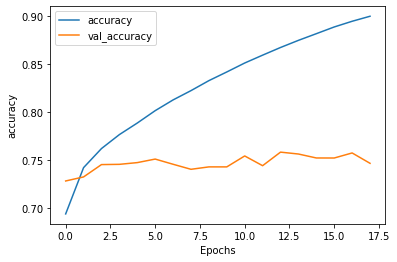

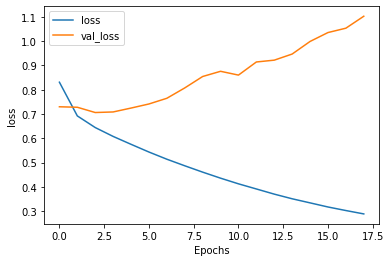

In [60]:

vocab_size = 30000
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(192, activation = 'relu'),
tf.keras.layers.Dense(96, activation='relu'),
tf.keras.layers.Dense(48, activation='relu'),
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 18
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#  SGD - Optimization

Train on 202696 samples, validate on 50674 samples
Epoch 1/18
202696/202696 - 8s - loss: 1.1789 - accuracy: 0.6209 - val_loss: 1.1561 - val_accuracy: 0.6245
Epoch 2/18
202696/202696 - 8s - loss: 1.1602 - accuracy: 0.6209 - val_loss: 1.1535 - val_accuracy: 0.6245
Epoch 3/18
202696/202696 - 8s - loss: 1.1587 - accuracy: 0.6209 - val_loss: 1.1527 - val_accuracy: 0.6245
Epoch 4/18
202696/202696 - 8s - loss: 1.1579 - accuracy: 0.6209 - val_loss: 1.1554 - val_accuracy: 0.6245
Epoch 5/18
202696/202696 - 8s - loss: 1.1572 - accuracy: 0.6209 - val_loss: 1.1513 - val_accuracy: 0.6245
Epoch 6/18
202696/202696 - 8s - loss: 1.1568 - accuracy: 0.6209 - val_loss: 1.1512 - val_accuracy: 0.6245
Epoch 7/18
202696/202696 - 8s - loss: 1.1560 - accuracy: 0.6209 - val_loss: 1.1496 - val_accuracy: 0.6245
Epoch 8/18
202696/202696 - 8s - loss: 1.1554 - accuracy: 0.6209 - val_loss: 1.1489 - val_accuracy: 0.6245
Epoch 9/18
202696/202696 - 8s - loss: 1.1539 - accuracy: 0.6209 - val_loss: 1.1462 - val_accuracy: 0.

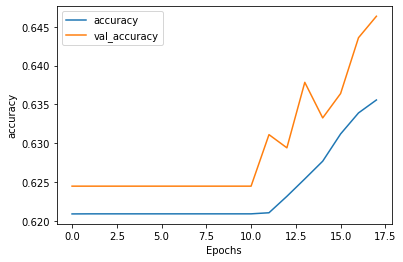

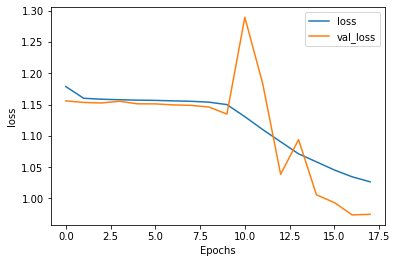

In [53]:
# different optimization (SGD)

vocab_size = 20000
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(96, activation='relu'),
tf.keras.layers.Dense(48, activation='relu'),
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

num_epochs = 18
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

the above graphs show that it needs more epochs to improve val_accuracy and to decrease val_loss

Train on 202696 samples, validate on 50674 samples
Epoch 1/50
202696/202696 - 8s - loss: 1.1763 - accuracy: 0.6208 - val_loss: 1.1549 - val_accuracy: 0.6245
Epoch 2/50
202696/202696 - 8s - loss: 1.1598 - accuracy: 0.6209 - val_loss: 1.1537 - val_accuracy: 0.6245
Epoch 3/50
202696/202696 - 8s - loss: 1.1586 - accuracy: 0.6209 - val_loss: 1.1516 - val_accuracy: 0.6245
Epoch 4/50
202696/202696 - 8s - loss: 1.1581 - accuracy: 0.6209 - val_loss: 1.1517 - val_accuracy: 0.6245
Epoch 5/50
202696/202696 - 8s - loss: 1.1576 - accuracy: 0.6209 - val_loss: 1.1541 - val_accuracy: 0.6245
Epoch 6/50
202696/202696 - 8s - loss: 1.1570 - accuracy: 0.6209 - val_loss: 1.1533 - val_accuracy: 0.6245
Epoch 7/50
202696/202696 - 8s - loss: 1.1564 - accuracy: 0.6209 - val_loss: 1.1500 - val_accuracy: 0.6245
Epoch 8/50
202696/202696 - 8s - loss: 1.1553 - accuracy: 0.6209 - val_loss: 1.1478 - val_accuracy: 0.6245
Epoch 9/50
202696/202696 - 8s - loss: 1.1528 - accuracy: 0.6209 - val_loss: 1.1425 - val_accuracy: 0.

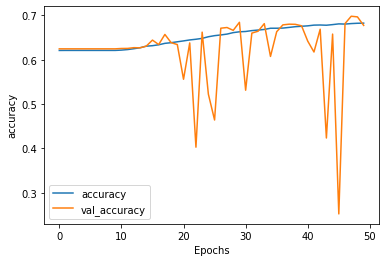

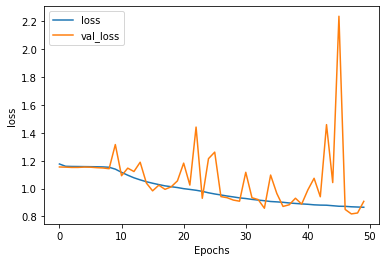

In [54]:
# different optimization (SGD) with 50 epochs

vocab_size = 20000
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(96, activation='relu'),
tf.keras.layers.Dense(48, activation='relu'),
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

num_epochs = 50
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# RNN with LSTM

In [18]:
vocab_size = 3000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [96]:
# rnn_1
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/30
202696/202696 - 322s - loss: 0.8524 - accuracy: 0.6854 - val_loss: 0.7693 - val_accuracy: 0.7124
Epoch 2/30
202696/202696 - 314s - loss: 0.7495 - accuracy: 0.7172 - val_loss: 0.7406 - val_accuracy: 0.7212
Epoch 3/30
202696/202696 - 321s - loss: 0.7051 - accuracy: 0.7347 - val_loss: 0.7092 - val_accuracy: 0.7352
Epoch 4/30
202696/202696 - 321s - loss: 0.6704 - accuracy: 0.7475 - val_loss: 0.6986 - val_accuracy: 0.7385
Epoch 5/30
202696/202696 - 326s - loss: 0.6450 - accuracy: 0.7582 - val_loss: 0.6983 - val_accuracy: 0.7409
Epoch 6/30
202696/202696 - 321s - loss: 0.6237 - accuracy: 0.7678 - val_loss: 0.6863 - val_accuracy: 0.7492
Epoch 7/30
202696/202696 - 305s - loss: 0.6043 - accuracy: 0.7763 - val_loss: 0.6839 - val_accuracy: 0.7529
Epoch 8/30
202696/202696 - 307s - loss: 0.5855 - accuracy: 0.7855 - val_loss: 0.6815 - val_accuracy: 0.7556
Epoch 9/30
202696/202696 - 311s - loss: 0.5695 - accuracy: 0.7928 - val_loss: 0.6987 

In [109]:
model.save('rnn_1.h5')
model.save_weights('rnn_1_weights.h5')
rnn_1 = {'rnn_1_val_acc': history.history['val_accuracy'],
        'rnn_1_val_loss': history.history['val_loss']}
rnn_1_df = pd.DataFrame(rnn_1)
#rnn_1_df.to_pickle('rnn_1.pkl')

In [142]:
vocab_size = 30000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8


# rnn_1
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 8
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=0)

model.save('rnn_2.h5')
model.save_weights('rnn_2_weights.h5')

rnn_2 = {'rnn_2_val_acc': history.history['val_accuracy'],
        'rnn_2_val_loss': history.history['val_loss']}
rnn_2_df = pd.DataFrame(rnn_2)
rnn_2_df.to_pickle('rnn_2.pkl')

In [197]:
rnn_2_df

,rnn_2_val_acc,rnn_2_val_loss
0,0.728677,0.730940
1,0.744978,0.694423
2,0.759443,0.665813
3,0.764238,0.667672
4,0.769251,0.680651
5,0.764791,0.699273
6,0.767474,0.721949
7,0.764080,0.756395
8,0.765560,0.785862


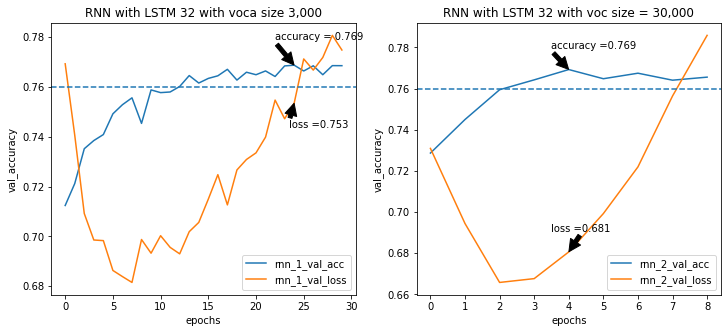

In [307]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

val_loss_index = rnn_1_df.rnn_1_val_acc.idxmax()
max_acc=rnn_1_df['rnn_1_val_acc'].max()
text = 'accuracy = {:.3f}'.format(max_acc)
loss=rnn_1_df.iloc[val_loss_index]['rnn_1_val_loss']
text_loss = 'loss ={:.3f}'.format(loss)
rnn_1_df.plot(ax = ax[0])
ax[0].annotate(text, xy=(val_loss_index,max_acc), xytext=(val_loss_index-2, max_acc+0.01), arrowprops=dict(facecolor='black', shrink=0.01))
ax[0].annotate(text_loss, xy=(val_loss_index,loss), xytext=(val_loss_index-0.5, loss-0.01), arrowprops=dict(facecolor='black', shrink=0.01))
ax[0].set_title('RNN with LSTM 32 with voca size 3,000')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('val_accuracy')
ax[0].axhline(0.76, linestyle = '--')
ax[0].legend(loc ='lower right')

val_loss_index_2 = rnn_2_df.rnn_2_val_acc.idxmax()
max_acc_2=rnn_2_df['rnn_2_val_acc'].max()
loss_2=rnn_2_df.iloc[val_loss_index_2]['rnn_2_val_loss']
text_2_acc = 'accuracy ={:.3f}'.format(max_acc)
text_2_loss = 'loss ={:.3f}'.format(loss_2)
rnn_2_df.plot(ax = ax[1])
ax[1].annotate(text_2_acc, xy=(val_loss_index_2,max_acc_2), xytext=(val_loss_index_2-0.5, max_acc_2+0.01), arrowprops=dict(facecolor='black', shrink=0.01))
ax[1].annotate(text_2_loss, xy=(val_loss_index_2,loss_2), xytext=(val_loss_index_2-0.5, loss_2+0.01), arrowprops=dict(facecolor='black', shrink=0.01))
ax[1].set_title('RNN with LSTM 32 with voc size = 30,000')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('val_accuracy')
ax[1].axhline(0.76, linestyle = '--')
ax[1].legend(loc ='lower right');

plt.savefig('different_voca_size')

- The estimated time of the first graph was 300s * 24/60s -> 2 hour

- The estimated time of the second graph was 800s * 4/60s -> 0.8 hour

Therefore, I am going to use 30,000 as the voca size and run models with less epochs later on

# RNN with two layer for LSTM, Dropout = 0.2 

In [146]:
# rnn_3
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_text)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences= True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences= False)),    
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 5
history_rnn2 = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/5
202696/202696 - 1655s - loss: 0.9080 - accuracy: 0.6697 - val_loss: 0.7928 - val_accuracy: 0.7004
Epoch 2/5
202696/202696 - 1112s - loss: 0.7253 - accuracy: 0.7266 - val_loss: 0.7009 - val_accuracy: 0.7409
Epoch 3/5
202696/202696 - 1015s - loss: 0.6497 - accuracy: 0.7586 - val_loss: 0.6681 - val_accuracy: 0.7551
Epoch 4/5
202696/202696 - 1005s - loss: 0.6019 - accuracy: 0.7790 - val_loss: 0.6689 - val_accuracy: 0.7581
Epoch 5/5
202696/202696 - 1002s - loss: 0.5666 - accuracy: 0.7934 - val_loss: 0.6764 - val_accuracy: 0.7629


it might need more epochs since I feel like there is possiblity to imporve the val_accuracy score without tradeoff of val_loss

In [ ]:
model.save('rnn_3.h5')
model.save_weights('rnn_3_weights.h5')
rnn_3= {'rnn_3_val_acc': history_rnn2.history['val_accuracy'],
        'rnn_3_val_loss': history_rnn2.history['val_loss']}
rnn_3_df = pd.DataFrame(rnn_3)

In [186]:
rnn_3_df.to_pickle('rnn_3_df.pkl')

In [185]:
model4 = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences= True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences= False)),    
tf.keras.layers.Dense(24, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 8
history_rnn4 = model4.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/8
202696/202696 - 1035s - loss: 0.5381 - accuracy: 0.8050 - val_loss: 0.6800 - val_accuracy: 0.7663
Epoch 2/8
202696/202696 - 1034s - loss: 0.5148 - accuracy: 0.8140 - val_loss: 0.6750 - val_accuracy: 0.7682
Epoch 3/8
202696/202696 - 1033s - loss: 0.4927 - accuracy: 0.8224 - val_loss: 0.6845 - val_accuracy: 0.7628
Epoch 4/8
202696/202696 - 1035s - loss: 0.4719 - accuracy: 0.8305 - val_loss: 0.6872 - val_accuracy: 0.7687
Epoch 5/8
202696/202696 - 1039s - loss: 0.4540 - accuracy: 0.8369 - val_loss: 0.7208 - val_accuracy: 0.7667
Epoch 6/8
202696/202696 - 1043s - loss: 0.4381 - accuracy: 0.8437 - val_loss: 0.7109 - val_accuracy: 0.7676
Epoch 7/8
202696/202696 - 1053s - loss: 0.4241 - accuracy: 0.8486 - val_loss: 0.7358 - val_accuracy: 0.7689
Epoch 8/8
202696/202696 - 1067s - loss: 0.4123 - accuracy: 0.8529 - val_loss: 0.7281 - val_accuracy: 0.7699


In [29]:
# Convolution
kernel_size = 5
filters = 64
pool_size = 4
# LSTM
lstm_output_size = 70

# LSTM with Conv1D ->Score "77.06%"

In [199]:
model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model5.add(Dropout(0.25))
model5.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model5.add(MaxPooling1D(pool_size=pool_size))
model5.add(LSTM(lstm_output_size, dropout = 0.2, return_sequences= False))
model5.add(Dense(24, activation='relu'))
model5.add(Dense(6, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 10
history_rnn5 = model5.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 202696 samples, validate on 50674 samples
Epoch 1/10
202696/202696 - 121s - loss: 0.8802 - accuracy: 0.6798 - val_loss: 0.7371 - val_accuracy: 0.7239
Epoch 2/10
202696/202696 - 135s - loss: 0.6988 - accuracy: 0.7381 - val_loss: 0.6822 - val_accuracy: 0.7498
Epoch 3/10
202696/202696 - 127s - loss: 0.6386 - accuracy: 0.7612 - val_loss: 0.6663 - val_accuracy: 0.7554
Epoch 4/10
202696/202696 - 131s - loss: 0.5966 - accuracy: 0.7779 - val_loss: 0.6622 - val_accuracy: 0.7617
Epoch 5/10
202696/202696 - 128s - loss: 0.5669 - accuracy: 0.7894 - val_loss: 0.6535 - val_accuracy: 0.7651
Epoch 6/10
202696/202696 - 135s - loss: 0.5425 - accuracy: 0.7980 - val_loss: 0.6530 - val_accuracy: 0.7687
Epoch 7/10
202696/202696 - 128s - loss: 0.5243 - accuracy: 0.8053 - val_loss: 0.6530 - val_accuracy: 0.7677
Epoch 8/10
202696/202696 - 128s - loss: 0.5075 - accuracy: 0.8114 - val_loss: 0.6509 - val_accuracy: 0.7701
Epoch 9/10
202696/202696 - 128s - loss: 0.4942 - accuracy: 0.8163 - val_loss: 0.6557 

In [200]:
model5.save('rnn_5.h5')
model5.save_weights('rnn_5_weights.h5')
rnn_5= {'rnn_5_val_acc': history_rnn5.history['val_accuracy'],
        'rnn_5_val_loss': history_rnn5.history['val_loss']}
rnn_5_df = pd.DataFrame(rnn_5)
rnn_5_df.to_pickle("rnn_5.pkl")

# LSTM & Conv1D & 15 epochs -> Best Score 77.64%

In [201]:
model6 = Sequential()
model6.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model6.add(Dropout(0.25))
model6.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model6.add(MaxPooling1D(pool_size=pool_size))
model6.add(LSTM(lstm_output_size, dropout = 0.2, return_sequences= False))
model6.add(Dense(24, activation='relu'))
model6.add(Dense(6, activation='softmax'))

model6.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 15
history_rnn6 = model6.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)



Train on 202696 samples, validate on 50674 samples
Epoch 1/15
202696/202696 - 126s - loss: 0.8363 - accuracy: 0.6934 - val_loss: 0.7347 - val_accuracy: 0.7338
Epoch 2/15
202696/202696 - 130s - loss: 0.6872 - accuracy: 0.7422 - val_loss: 0.6792 - val_accuracy: 0.7482
Epoch 3/15
202696/202696 - 128s - loss: 0.6320 - accuracy: 0.7646 - val_loss: 0.6641 - val_accuracy: 0.7574
Epoch 4/15
202696/202696 - 132s - loss: 0.5920 - accuracy: 0.7794 - val_loss: 0.6523 - val_accuracy: 0.7625
Epoch 5/15
202696/202696 - 131s - loss: 0.5631 - accuracy: 0.7906 - val_loss: 0.6604 - val_accuracy: 0.7646
Epoch 6/15
202696/202696 - 135s - loss: 0.5387 - accuracy: 0.7999 - val_loss: 0.6570 - val_accuracy: 0.7648
Epoch 7/15
202696/202696 - 132s - loss: 0.5209 - accuracy: 0.8063 - val_loss: 0.6509 - val_accuracy: 0.7686
Epoch 8/15
202696/202696 - 132s - loss: 0.5016 - accuracy: 0.8133 - val_loss: 0.6656 - val_accuracy: 0.7686
Epoch 9/15
202696/202696 - 131s - loss: 0.4886 - accuracy: 0.8197 - val_loss: 0.6648 

In [210]:
model6.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 120, 16)           480000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 116, 64)           5184      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 70)                37800     
_________________________________________________________________
dense_31 (Dense)             (None, 24)                1704      
_________________________________________________________________
dense_32 (Dense)             (None, 6)               

In [202]:
#model6.save('rnn_6.h5')
#model6.save_weights('rnn_5_weights.h5')
#rnn_6= {'rnn_5_val_acc': history_rnn6.history['val_accuracy'],'rnn_5_val_loss': history_rnn6.history['val_loss']}
#rnn_6_df = pd.DataFrame(rnn_6)
#rnn_6_df.to_pickle("rnn_6.pkl")

In [231]:
score = model6.evaluate(validation_padded, validation_label_seq, verbose=0)
score

[0.6799056202228516, 0.7763942]

In [ ]:
y_pre = model6.predict(validation_label_seq)

In [248]:
test = np.argmax(y_pre, axis = -1)

In [308]:
cols = ['5', '4', '1', '3', '2']
print(classification_report(validation_label_seq, test, target_names = cols))

              precision    recall  f1-score   support

           5       0.85      0.94      0.89     31645
           4       0.60      0.40      0.48      7168
           1       0.71      0.73      0.72      5053
           3       0.54      0.48      0.51      4042
           2       0.53      0.41      0.46      2766

    accuracy                           0.78     50674
   macro avg       0.65      0.59      0.61     50674
weighted avg       0.76      0.78      0.76     50674



In [253]:
model7 = Sequential()
model7.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model7.add(Dropout(0.25))
model7.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model7.add(MaxPooling1D(pool_size=pool_size))
model7.add(LSTM(lstm_output_size, dropout = 0.2, return_sequences= False))
model7.add(Dense(24, activation='relu'))
model7.add(Dense(6, activation='softmax'))

model7.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 20
history_rnn7 = model7.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


Train on 202696 samples, validate on 50674 samples
Epoch 1/20
202696/202696 - 135s - loss: 0.8654 - accuracy: 0.6844 - val_loss: 0.7294 - val_accuracy: 0.7157
Epoch 2/20
202696/202696 - 133s - loss: 0.6966 - accuracy: 0.7388 - val_loss: 0.6803 - val_accuracy: 0.7498
Epoch 3/20
202696/202696 - 133s - loss: 0.6382 - accuracy: 0.7621 - val_loss: 0.6657 - val_accuracy: 0.7563
Epoch 4/20
202696/202696 - 134s - loss: 0.5972 - accuracy: 0.7771 - val_loss: 0.6600 - val_accuracy: 0.7625
Epoch 5/20
202696/202696 - 135s - loss: 0.5682 - accuracy: 0.7889 - val_loss: 0.6658 - val_accuracy: 0.7565
Epoch 6/20
202696/202696 - 126s - loss: 0.5415 - accuracy: 0.7993 - val_loss: 0.6670 - val_accuracy: 0.7663
Epoch 7/20
202696/202696 - 140s - loss: 0.5223 - accuracy: 0.8062 - val_loss: 0.6646 - val_accuracy: 0.7664
Epoch 8/20
202696/202696 - 2757s - loss: 0.5070 - accuracy: 0.8118 - val_loss: 0.6694 - val_accuracy: 0.7696
Epoch 9/20
202696/202696 - 133s - loss: 0.4926 - accuracy: 0.8168 - val_loss: 0.6691

In [264]:
model7.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 120, 16)           480000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 116, 64)           5184      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 70)                37800     
_________________________________________________________________
dense_33 (Dense)             (None, 24)                1704      
_________________________________________________________________
dense_34 (Dense)             (None, 6)               

In [265]:
model7.save('rnn_7.h5')
model7.save_weights('rnn_7_weights.h5')
rnn_7= {'rnn_7_val_acc': history_rnn7.history['val_accuracy'],'rnn_7_val_loss': history_rnn7.history['val_loss']}
rnn_7_df = pd.DataFrame(rnn_7)
rnn_7_df.to_pickle("rnn_7.pkl")

In [ ]:
score_1 = model7.evaluate(validation_padded, validation_label_seq, verbose=0)

In [263]:
score_1

[0.6886306833852959, 0.77797294]

In [256]:
y_pre_1 = model7.predict(validation_padded)

In [298]:
test_1 = np.argmax(y_pre_1, axis = -1)

# tensforflow labeling score does differently. -> the highest frequency of score is labelled as 1, the least frequnecy of socre is labelled as 5 
cols = ['5', '4', '1', '3', '2']
print(classification_report(validation_label_seq, test_1, target_names = cols))

              precision    recall  f1-score   support

           5       0.84      0.95      0.89     31645
           4       0.65      0.37      0.47      7168
           1       0.69      0.75      0.72      5053
           3       0.57      0.46      0.51      4042
           2       0.57      0.39      0.46      2766

    accuracy                           0.78     50674
   macro avg       0.66      0.58      0.61     50674
weighted avg       0.76      0.78      0.76     50674



In [303]:
x = np.arange(1,6)
x

array([1, 2, 3, 4, 5])

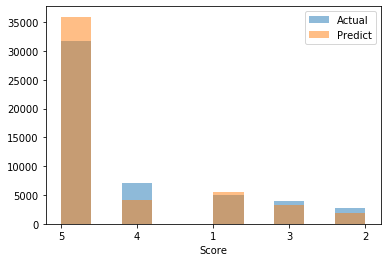

In [306]:
fig, ax = plt.subplots()

ax.hist(validation_label_seq, label = 'Actual', alpha = 0.5)
ax.hist(test_1, alpha = 0.5, label = 'Predict')
x = np.arange(1,6)
labels = ['5', '4','1','3','2']

#ax.set_xticks(x)
#ax.set_xticklabels(squad, minor=False, rotation=45)
plt.xticks(x,labels)
plt.xlabel('Score')
plt.legend();
plt.savefig('pre_act_best_model.png')

In [30]:
model8 = Sequential()
model8.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model8.add(Dropout(0.25))
model8.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model8.add(MaxPooling1D(pool_size=pool_size))
model8.add(LSTM(lstm_output_size, dropout = 0.2, return_sequences= False))
model8.add(Dense(24, activation='relu'))
model8.add(Dense(6, activation='softmax'))

model8.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30
history_rnn8 = model8.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


Train on 202696 samples, validate on 50674 samples
Epoch 1/30
202696/202696 - 106s - loss: 0.8545 - accuracy: 0.6872 - val_loss: 0.7458 - val_accuracy: 0.7183
Epoch 2/30
202696/202696 - 105s - loss: 0.7365 - accuracy: 0.7238 - val_loss: 0.7177 - val_accuracy: 0.7307
Epoch 3/30
202696/202696 - 105s - loss: 0.7068 - accuracy: 0.7332 - val_loss: 0.7071 - val_accuracy: 0.7350
Epoch 4/30
202696/202696 - 106s - loss: 0.6857 - accuracy: 0.7416 - val_loss: 0.6841 - val_accuracy: 0.7436
Epoch 5/30
202696/202696 - 105s - loss: 0.6711 - accuracy: 0.7459 - val_loss: 0.6866 - val_accuracy: 0.7435
Epoch 6/30
202696/202696 - 106s - loss: 0.6578 - accuracy: 0.7509 - val_loss: 0.6790 - val_accuracy: 0.7489
Epoch 7/30
202696/202696 - 168s - loss: 0.6483 - accuracy: 0.7558 - val_loss: 0.6699 - val_accuracy: 0.7517
Epoch 8/30
202696/202696 - 106s - loss: 0.6400 - accuracy: 0.7588 - val_loss: 0.6662 - val_accuracy: 0.7557
Epoch 9/30
202696/202696 - 106s - loss: 0.6314 - accuracy: 0.7625 - val_loss: 0.6657 

# test for different embedding_dims

In [32]:
embedding_dims = [8,16,50,100]

loss = {}
acc = {}
for n in embedding_dims:
    model = Sequential()
    model.add(Embedding(vocab_size, n, input_length=max_length))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size, dropout = 0.2, return_sequences= False))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    num_epochs = 20
    history = model.fit(train_padded, training_label_seq, 
                        epochs=num_epochs, 
                        validation_data=(validation_padded, validation_label_seq), verbose=0)
    loss['loss' + " " + str(n)] = history.history['loss']
    loss['val_loss' +  " " + str(n)] = history.history['val_loss']
    acc['acc' + " " + str(n)] = history.history['accuracy']
    acc['val_acc' + " " + str(n)] = history.history['val_accuracy']
     

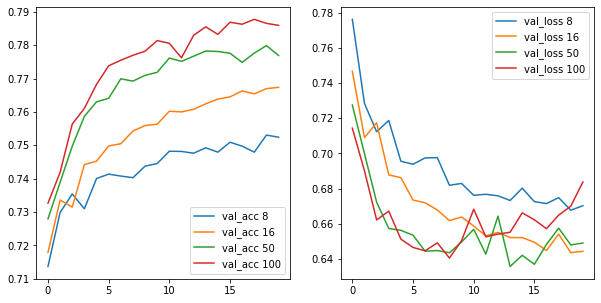

In [36]:
loss_dim_df_size=pd.DataFrame(loss)
acc_dim_df_size = pd.DataFrame(acc)
interested_cols = [col for col in acc_dim_df_size.columns if col.startswith('val')]
interested_cols_1 = [col for col in loss_dim_df_size.columns if col.startswith('val')]
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (10,5))
acc_dim_df_size[interested_cols].plot(ax = axs[0])
loss_dim_df_size[interested_cols_1].plot(ax = axs[1])
#plt.title('Embedding Dimention');
plt.savefig('../src/embedding_dimention.png')

higher number of embedding dimension hit the highest accuracy score faster. test it one more time

In [25]:
# New_features
vocab_size = 30000
# Convolution
kernel_size = 5
filters = 64
pool_size = 4
# LSTM
lstm_output_size = 70

In [34]:
from datetime import datetime

In [38]:
start_time = datetime.now()
max_lengths = [200,400]

loss = {}
acc = {}
for n in max_lengths:
    vocab_size = n
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_text)
    word_index = tokenizer.word_index

    train_sequences = tokenizer.texts_to_sequences(train_text)
    train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=n)
    
    validation_sequences = tokenizer.texts_to_sequences(test_text)
    validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=n)
    
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=n))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size, dropout = 0.2, return_sequences= False))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    num_epochs = 10
    history = model.fit(train_padded, training_label_seq, 
                        epochs=num_epochs, 
                        validation_data=(validation_padded, validation_label_seq), verbose=0)
    loss['loss_embedding_dim' + " " + str(n)] = history.history['loss']
    loss['val_loss_embedding_dim' +  " " + str(n)] = history.history['val_loss']
    acc['acc_embedding_dim' + " " + str(n)] = history.history['accuracy']
    acc['val_acc_embedding_dim' + " " + str(n)] = history.history['val_accuracy']

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

KeyboardInterrupt: 